# The University of Maryland: College Town or Crime Town?

Jessica Hatfield and Nate Ostrander<br/>
CMSC320 Fall 2017

# Assessing arrest data

All of us have received the infamous <a href="https://alert.umd.edu/">UMD Alerts</a> notifying us of the latest theft, burglary, or assault. However, we rarely find out when arrests are made. The purpose of this project is to assess arrest data from the <a href="http://www.umpd.umd.edu/">University of Maryland Police Department</a> and identify patterns over time. We chose to use UMD arrest data because, as students at the University of Maryland, we think that it is important to understand crime on campus.

<h2>Table of contents</h2>

The data lifecycle was an important, recurring element of our class; therefore, we will structure our tutorial around the steps of the data lifecycle.

<ul>
    <li><a href="#Getting-started">Getting started</a></li>
    <li><a href="#Data-collection-and-processing">Data collection and processing</a></li>
    <li><a href="#Exploratory-data-analysis-and-visualization">Exploratory data analysis and visualization</a></li>
    <li><a href="#Analysis-and-hypothesis-testing">Analysis and hypothesis testing</a></li>
    <li><a href="#Insight">Insight</a></li>
</ul>

# Getting started

We will be using <a href="https://www.python.org/downloads/release/python-350/">```Python3.5```</a> as well as the following python libraries:
<ul>
    <li><a href="https://www.crummy.com/software/BeautifulSoup/">```BeautifulSoup```</a></li>
    <li><a href="http://docs.python-requests.org/en/master/">```requests```</a></li>
    <li><a href="https://pandas.pydata.org/">```pandas```</a></li>
    <li><a href="http://www.numpy.org/">```numpy```</a></li>
    <li><a href="https://matplotlib.org/api/pyplot_api.html">```matplotlib.pyplot```</a></li>
</ul>

Below is the code to import the necessary libraries.

In [17]:
from bs4 import BeautifulSoup
import requests as req
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn

# Data collection and processing

We are getting our data from the <a href="http://www.umpd.umd.edu/stats/arrest_report.cfm">University of Maryland Police Department's Crime Stats</a> website. We are using the arrest data for the past seven years, i.e. from 2010 to 2017, because the data from the years 2006 to 2009 is not available. It is important to note that the UMPD updates their arrest data every day, so the data for 2017 will change as the semester progresses.

<h2>Collection</h2>

To collect the data from the webpage, we are using the python ```requests``` and ```BeautifulSoup``` libraries and storing the data in a ```pandas dataframe```. Below is an example of UMPD arrest data from 2010. As you can see, because the HTML table contains ```rowspans``` and ```colspans```, information corresponding to each arrest record is spread out across two rows of the ```dataframe```. We cannot make any reasonable analyses with the data in this form; therefore, we need to process it more.

In [2]:
r = req.get('http://www.umpd.umd.edu/stats/arrest_report.cfm?year=2010')
text = r.text
soup = BeautifulSoup(text, 'html.parser')
table = soup.find('table')
df = pd.read_html(str(table), flavor='bs4')[0]
df.head()

,0,1,2,3,4,5
0,ARRESTNUMBER,ARRESTED DATE TIMECHARGE,UMPD CASE NUMBER,AGE,RACE,SEX
1,16001,11/09/10 23:30,2010-00000115,NaN,Black,Male
2,CDS: Possess Paraphernalia,NaN,NaN,NaN,NaN,NaN
3,16002,11/10/10 00:20,2010-00000126,NaN,Black,Male
4,"Theft: $1,000 to Under $10,000",NaN,NaN,NaN,NaN,NaN


<h2>Processing</h2>

Next, we need to clean up and process the data. The problems resulting from ```rowspans``` and ```colpans``` are solved by moving the decription from the second row of the corresponding arrest record's data into a ```description``` column in the first row and removing the second row completely. Additionally, a ```year``` column is added to the dataframe for easy access to each year's data. After individual ```dataframes``` are created for each year from 2010 to 2017, they are concatenated together to form one large ```dataframe``` that contains the arrest data for every year from 2010 to 2017.

In [3]:
frames = []

# Have to make separate requests for every year
for i in range(2010, 2018):

    # Putting the data into a dataframe
    r = req.get('http://www.umpd.umd.edu/stats/arrest_report.cfm?year=' + str(i))
    text = r.text
    soup = BeautifulSoup(text, 'html.parser')
    table = soup.find('table')
    df = pd.read_html(str(table), flavor='bs4')[0]
    
    df.drop(df.index[:1], inplace=True)
    df.columns = ['arrest_number', 'date_time', 'case_number', 'age', 'race', 'gender']
    df['description'] = ''
    df['year'] = 0
    
    # Fixing issues caused by the row and colspans
    for index in range(1, df.shape[0]):
        descr = df.get_value(index + 1, 'arrest_number')
        df.set_value(index, 'description', descr)
        df.set_value(index, 'year', i)
    
    # Removing every other row
    df = df.iloc[::2]
    
    # Adding current df to the list of dataframes
    frames.append(df)

# Combining individual dataframes
dataframe = pd.concat(frames)
dataframe.reset_index(inplace=True, drop=True)

dataframe.head()

,arrest_number,date_time,case_number,age,race,gender,description,year
0,16001,11/09/10 23:30,2010-00000115,NaN,Black,Male,CDS: Possess Paraphernalia,2010
1,16002,11/10/10 00:20,2010-00000126,NaN,Black,Male,"Theft: $1,000 to Under $10,000",2010
2,16003,11/10/10 00:20,2010-00000126,NaN,Black,Male,"Theft: $1,000 to Under $10,000",2010
3,16005,11/10/10 22:44,2010-00000292,NaN,White,Male,"(Driving, Attempting to drive) veh. while unde...",2010
4,16006,11/11/10 17:54,2010-00000414,NaN,White,Male,"(Driving, Attempting to drive) motor veh. on h...",2010


Next, the values from the ```date_time``` column are converted into ```python``` ```datetime``` objects.

In [4]:
# Changing everything in the date_time column to python datetime objects
for index, row in dataframe.iterrows():
    date = dataframe.get_value(index, 'date_time').split(' ')[0].split('/')
    time = dataframe.get_value(index, 'date_time').split(' ')[1].split(':')
    dt = datetime.datetime(int(date[2]) + 2000, int(date[0]), int(date[1]), int(time[0]), int(time[1]))
    dataframe.set_value(index, 'date_time', dt)
    
dataframe.head()

,arrest_number,date_time,case_number,age,race,gender,description,year
0,16001,2010-11-09 23:30:00,2010-00000115,NaN,Black,Male,CDS: Possess Paraphernalia,2010
1,16002,2010-11-10 00:20:00,2010-00000126,NaN,Black,Male,"Theft: $1,000 to Under $10,000",2010
2,16003,2010-11-10 00:20:00,2010-00000126,NaN,Black,Male,"Theft: $1,000 to Under $10,000",2010
3,16005,2010-11-10 22:44:00,2010-00000292,NaN,White,Male,"(Driving, Attempting to drive) veh. while unde...",2010
4,16006,2010-11-11 17:54:00,2010-00000414,NaN,White,Male,"(Driving, Attempting to drive) motor veh. on h...",2010


After the data is properly organized, our next goal is to categorize the descriptions by type of incident. We are removing all rows that have ```NaN``` descriptions becasue we feel that if the incident was not properly reported, we will not be able to draw any conclusions from it.

In [16]:
dataframe = dataframe.dropna(subset=['description'])

# Finding all unique descriptions
crimes = dataframe.groupby('description')
# i = 0
# for name, group in crimes:
#     i = i + 1
#     print(str(i) + ": " + str(name) + '\n')

print('Number of unique crimes: ' + str(len(crimes)))

Number of unique crimes: 910


It is apparent that there are far too many incident types when we attempt to group by description alone. Most of these "unique" descriptions describe the same type of incident as well. To solve this problem, we are going to define ```incident_types``` as a list of crime descriptors that appear multiple times in ```descriptions```. With these ```incident_types```, we will be able to generalize the offense of each incident by looking for keywords in the description.

In [9]:
# Keywords to search for
incident_types = ['driving', 'w/o req. license and authorization', 'alcohol', 'urinating','drug', 'suspended lic', 'disorderly conduct', 'fictitious lic', 'trespass', 'theft', 'marijuana', 'rogue and vagabond', 'robbery', 'rape', 'resist', 'molest', 'obstructing and hindering', 'destruction property', 'handgun', 'murder', 'assault', 'burglary', 'cds', 'credit card', 'deadly weapon', 'false documentation']

# credic card = theft
# suspended lic + fictitious lic = false documentation
# CDS = controled dangerous substance
# Rogue and Vagabond = breaking and entering vehicle

# Map of keywords to offenses
offense_types = {'alcohol': 'Alcohol Related', 'Missing Proper Documentation': 'Missing Proper Documentation', 'DUI': 'DUI', 'urinating': 'Public Urination', 'drug': 'Drug Related', 'disorderly conduct': 'Disorderly Conduct', 'fictitious lic': 'False Documentation', 'trespass': "Trespassing", 'theft': 'Theft', 'marijuana': 'Marijuana', 'rogue and vagabond': 'Rogue and Vagabond', 'robbery': 'Robbery', 'rape': 'Rape', 'resist': 'Resisting Arrest', 'molest': 'Molestation', 'obstructing and hindering': 'Obstructing and Hindering', 'destruction property': 'Destruction of Property', 'handgun': 'Illegal Possession of Handgun', 'murder': 'Murder', 'assault': 'Assault', 'burglary': 'Burglary', 'cds': 'Controled Dangerous Substance', 'credit card': 'Theft', 'deadly weapon': 'Deadly Weapon', 'false documentation': 'False Documentation'}

# Map to keep track of the number of each offense
num_offenses = {'Missing Proper Documentation': 0, 'DUI': 0, 'Alcohol Related': 0, 'Public Urination': 0, 'Controled Dangerous Substance': 0, 'Drug Related': 0, 'Disorderly Conduct': 0, 'Trespassing': 0, 'Marijuana': 0, 'Rogue and Vagabond': 0, 'Robbery': 0, 'Rape': 0, 'Resisting Arrest': 0, 'Molestation': 0, 'Obstructing and Hindering': 0, 'Destruction of Property': 0, 'Illegal Possession of Handgun': 0, 'Murder': 0, 'Assault': 0, 'Burglary': 0, 'Theft': 0, 'Deadly Weapon': 0, 'False Documentation': 0}

dataframe['offense_types'] = None

for index, row in dataframe.iterrows():
    
    # Getting list of keywords present in current description
    result = list(filter(lambda x: x if x in row['description'].lower() else "", incident_types))
    
    if 'driving' in result and 'alcohol' in result:
        result.remove('alcohol')
        result.append('DUI')
    if 'driving' in result and 'w/o req. license and authorization' in result:
        result.remove('w/o req. license and authorization')
        result.append('Missing Proper Documentation')
    if 'driving' in result and 'suspended lic' in result:
        result.remove('suspended lic')
        result.append('Missing Proper Documentation')
    if 'driving' in result:
        result.remove('driving')

    for i, offense in enumerate(result):
        result[i] = offense_types[offense]
        num_offenses[result[i]]+= 1
    dataframe.set_value(index, 'offense_types', result)

dataframe.head()

,arrest_number,date_time,case_number,age,race,gender,description,year,offense_types
0,16001,2010-11-09 23:30:00,2010-00000115,NaN,Black,Male,CDS: Possess Paraphernalia,2010,[Controled Dangerous Substance]
1,16002,2010-11-10 00:20:00,2010-00000126,NaN,Black,Male,"Theft: $1,000 to Under $10,000",2010,[Theft]
2,16003,2010-11-10 00:20:00,2010-00000126,NaN,Black,Male,"Theft: $1,000 to Under $10,000",2010,[Theft]
3,16005,2010-11-10 22:44:00,2010-00000292,NaN,White,Male,"(Driving, Attempting to drive) veh. while unde...",2010,[DUI]
4,16006,2010-11-11 17:54:00,2010-00000414,NaN,White,Male,"(Driving, Attempting to drive) motor veh. on h...",2010,[Missing Proper Documentation]


Finally, our data is collected and clean!

# Exploratory data analysis and visualization

Before declaring a hypothesis, we want to understand our data better by visualizing it. First, we will plot the number of arrests against different units of time, such as year, month, day of the week, and hour of the day. Then, we will plot the number of incident types. Finally we will combine the two to see if certain types of arrests are more likely to occur in specific years, month, days, or hours.

<h2>Plotting by time</h2>

First, we will plot the number of arrests against year, month, day, and hour.

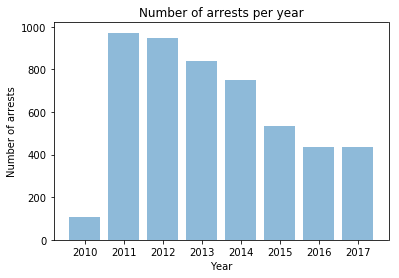

In [15]:
# Plotting by year

plt.close('all')

plt.title('Number of arrests per year')
plt.ylabel('Number of arrests')
plt.xlabel('Year')

num_arrests = []
for i in range(2010, 2018):
    num_arrests.append(len(dataframe.query('year == @i')))

plt.bar(range(2010, 2018), num_arrests, align='center', alpha=0.5)

plt.show()

With the exception of 2010, it seems clear from the plot above that the number of arrests at the University of Maryland has decreased since 2011. The discrepancy in 2010 could be due to faulty record keeping by the UMPD. Additionally, this plot could serve as a basis to the claim that crime has decreased at UMD over the past 6 years.

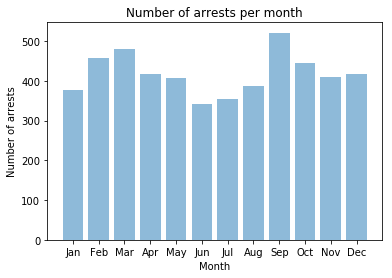

In [16]:
# Plotting by month

plt.close('all')

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.title('Number of arrests per month')
plt.ylabel('Number of arrests')
plt.xlabel('Month')
plt.xticks(range(1,13), months)

num_arrests = [0]*12
for index, row in dataframe.iterrows():
    month = dataframe.get_value(index, 'date_time').month
    num_arrests[month - 1] += 1
    
plt.bar(range(1,13), num_arrests, align='center', alpha=0.5)

plt.show()

Because a majority of the students attending the University of Maryland are present on campus from September to May, the drop in number of arrests over the summer in this plot is unsuprising. What is interesting to note; however, is that the highest number of arrests occur in September. This could be due to the increased number of parties off-campus during syllabus week and the start of football tailgating season.

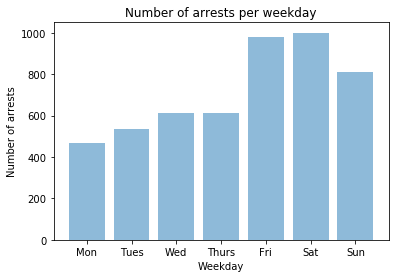

In [17]:
# Plotting by weekday

plt.close('all')

weekdays = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']

plt.title('Number of arrests per weekday')
plt.ylabel('Number of arrests')
plt.xlabel('Weekday')
plt.xticks(range(7), weekdays)

num_arrests = [0]*7
for index, row in dataframe.iterrows():
    weekday = dataframe.get_value(index, 'date_time').weekday()
    num_arrests[weekday] += 1
    
plt.bar(range(7), num_arrests, align='center', alpha=0.5)

plt.show()

As expected in a college town, the number of arrests at UMD is the highest on Fridays, Saturdays, and Sundays. This could be due to the fact that many college students go to bars or parties to drink on the weekends. However, it is important to note that this plot does not distinguish between types of arrests; therefore, it is unclear if most of the arrests on the weekends are alcohol related. 

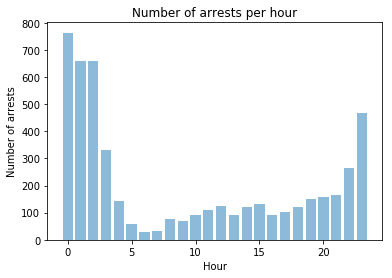

In [12]:
# Plotting by hour where 0 is 00:00, 5 is 05:00, and so on

plt.close('all')

plt.title('Number of arrests per hour')
plt.ylabel('Number of arrests')
plt.xlabel('Hour')

num_arrests = [0]*24
for index, row in dataframe.iterrows():
    hour = dataframe.get_value(index, 'date_time').hour
    num_arrests[hour] += 1

plt.bar(range(0, 24), num_arrests, align='center', alpha=0.5)

plt.show()

Before creating this plot, we could have guessed that most arrests occur late at night and in the early hours of the morning based on our previous knowledge of when crime is most likely to happen. After creating this plot, it is clear that this is true because the highest number of arrests occur between 23:00 and 03:00.

<h2>Plotting by offense type</h2>

Next, we will plot the occurrences of each offense grabbed from the arrest description. The number of offenses will be larger than the number of arrests because there can be multiple offenses for a single arrest.


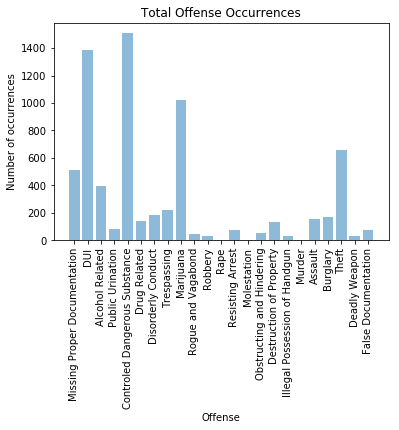

In [19]:
plt.close('all')

plt.title('Total Offense Occurrences')
plt.ylabel('Number of occurrences')
plt.xlabel('Offense')

plt.bar(range(len(num_offenses)), num_offenses.values(), align='center', alpha=0.5)
plt.xticks(range(len(num_offenses)), num_offenses.keys(), rotation='vertical')
plt.show()

<h2>Plotting by time and offense type</h2>

# Analysis and hypothesis testing

Probably some stat and regression stuff here.

# Insight

Conclusions and things that we learned.